In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler ,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM,Dropout, BatchNormalization, Dense

In [2]:
# Get the data for the SPY ETF by specifying the stock ticker, start date, and end date
data = yf.download('0005.hk',"2020-09-28","2021-09-24")
data.columns

[*********************100%***********************]  1 of 1 completed


Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [3]:
data_options = pd.read_csv("Put_Call_Ratio.csv",skiprows=1)
data_options.columns

Index(['Date (D/M/Y)', ' Call Volume', ' Put Volume', ' Put/Call Ratio'], dtype='object')

In [4]:
data_options['Date (D/M/Y)']=pd.to_datetime(data_options['Date (D/M/Y)'], format="%d/%m/%Y")
data_options.set_index('Date (D/M/Y)',inplace=True)
data_options.sort_index(ascending=True,inplace=True)
data_options.columns

Index([' Call Volume', ' Put Volume', ' Put/Call Ratio'], dtype='object')

In [5]:
data=pd.merge(data,data_options[" Put/Call Ratio"], left_index=True,right_index=True)
data.drop(['Volume',"Adj Close"], axis=1,inplace=True)
data['Prediction']=data['Close'].shift(-1)

In [6]:
data.isnull().sum()

Open               0
High               0
Low                0
Close              0
 Put/Call Ratio    0
Prediction         1
dtype: int64

In [7]:
# data[0:5,0:4]

In [8]:
train = data[0:int(len(data)*0.80)]
data_price=train["Prediction"]
train=train.values
# scl = MinMaxScaler()
# #Scale the data
# scl.fit(train.values.reshape(-1,1))
# cl =scl.transform(cl.values.reshape(-1,1))
sc = MinMaxScaler(feature_range=(0,1))
train=sc.fit_transform(train)
def processData(data,data_price,lb):
    X,Y = [],[]
    for i in range(len(data)-lb-1):
        X.append(data[i:(i+lb)])
        Y.append(data_price[(i+lb)])
    return np.array(X),np.array(Y)

lb=3
X,y = processData(train,data_price,lb)
X_train,X_test = X[:int(X.shape[0]*0.90)],X[int(X.shape[0]*0.90):]
y_train,y_test = y[:int(y.shape[0]*0.90)],y[int(y.shape[0]*0.90):]
print(X_train.shape[0],X_train.shape[1])
print(X_test.shape[0], X_test.shape[1])
print(y_train.shape[0])
print(y_test.shape[0])

171 3
20 3
171
20


In [9]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(171, 3, 6) (171,) (20, 3, 6) (20,)


In [10]:
model = keras.Sequential()
model.add(LSTM(units=128,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=64,  activation="relu"))
model.add(Dense(units=32, activation="relu"))
model.add(Dense(units=8, activation="relu"))
model.add(Dense(units=1, activation="relu"))
# model.add(keras.layers.LSTM(
#   units=128,
#   input_shape=(X_train.shape[1], X_train.shape[2])
# ))
# model.add(keras.layers.Dense(units=1))
model.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(learning_rate=0.001)
)

Metal device set to: Apple M1 Pro


2021-12-26 21:56:06.720225: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-26 21:56:06.720331: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
#Fit model with history to check for overfitting
history = model.fit(X_train,y_train,epochs=300,validation_data=(X_test,y_test),shuffle=False)
 
model.summary() 

Epoch 1/300


2021-12-26 21:56:06.907500: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-12-26 21:56:07.368662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-26 21:56:07.519126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-26 21:56:08.084340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 74ms/step - loss: 1838.5435 - val_loss: 1988.9977
Epoch 2/300
6/6 [==============================] - 0s 14ms/step - loss: 1781.6184 - val_loss: 1891.6478
Epoch 3/300
1/6 [====>.........................] - ETA: 0s - loss: 1119.1379

2021-12-26 21:56:08.606872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-26 21:56:08.657519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 14ms/step - loss: 1671.2804 - val_loss: 1691.2489
Epoch 4/300
6/6 [==============================] - 0s 14ms/step - loss: 1444.0352 - val_loss: 1295.6484
Epoch 5/300
6/6 [==============================] - 0s 15ms/step - loss: 1031.2202 - val_loss: 675.9080
Epoch 6/300
6/6 [==============================] - 0s 15ms/step - loss: 475.2851 - val_loss: 104.6970
Epoch 7/300
6/6 [==============================] - 0s 14ms/step - loss: 88.4958 - val_loss: 58.4707
Epoch 8/300
6/6 [==============================] - 0s 14ms/step - loss: 110.6155 - val_loss: 149.5784
Epoch 9/300
6/6 [==============================] - 0s 14ms/step - loss: 67.1329 - val_loss: 24.7624
Epoch 10/300
6/6 [==============================] - 0s 15ms/step - loss: 14.9736 - val_loss: 2.1317
Epoch 11/300
6/6 [==============================] - 0s 14ms/step - loss: 27.4030 - val_loss: 6.2764
Epoch 12/300
6/6 [==============================] - 0s 14ms/step - loss: 23.5581 - val_loss: 0.59

In [12]:
# history = model.fit(
#     X_train, y_train,
#     epochs=100,
#     batch_size=16,
#     validation_split=0.1,
#     verbose=1,
#     shuffle=False
# )

In [13]:
y_pred = model.predict(X_test)

2021-12-26 21:56:32.265202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-26 21:56:32.305277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


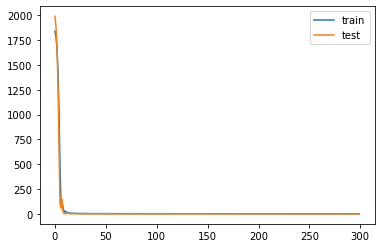

In [14]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

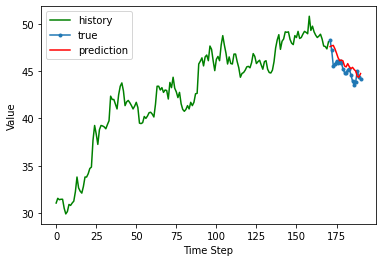

In [15]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

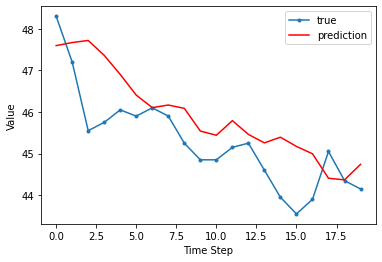

In [16]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();